In [1]:
# import networkx as nx
# import networkx.algorithms.community as nx_comm
# import matplotlib
# import matplotlib.pyplot as plt
# import matplotlib.ticker as mtick
# 
# import pandas as pd
# import seaborn as sns
# import numpy as np
# from pysankey import sankey

# %matplotlib inline

# matplotlib.use("pgf")
# sns.set_theme(style='white')
# plt.rcParams["axes.linewidth"] = 0.5
# plt.rcParams["legend.fontsize"] = 6.5
# plt.rcParams["xtick.labelsize"] = 8
# plt.rcParams["ytick.labelsize"] = 8
# plt.rcParams["ytick.left"] = True
# plt.rcParams['ytick.major.size'] = 5
# plt.rcParams['ytick.major.width'] = 0.5
# plt.rcParams['ytick.major.pad'] = 0
# plt.rcParams["xtick.bottom"] = True
# plt.rcParams['xtick.major.size'] = 5
# plt.rcParams['xtick.major.width'] = 0.5
# plt.rcParams['xtick.major.pad'] = 0
# plt.rcParams["pgf.texsystem"] = "pdflatex"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["text.usetex"] = True
# plt.rcParams["pgf.rcfonts"] = False
# plt.rcParams["axes.titlesize"] = 8
# plt.rcParams["legend.handletextpad"] = 0.3
# plt.rcParams['lines.markersize'] = 4
# plt.rcParams['savefig.pad_inches'] = 0.01
# 

#plt.style.use("seaborn-whitegrid")
#sns.set_palette("deep")
#sns.set_context("notebook")  # Set to "paper" for use in paper :)

#plt.rcParams['figure.figsize'] = (10, 6)

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sec_certs.dataset.fips import FIPSDataset
from collections import Counter

sns.set_palette("deep")

In [4]:
dset = FIPSDataset.from_web_latest()

In [5]:
df = dset.to_pandas()

In [6]:
df.head()

,cert_id,name,status,standard,type,level,embodiment,date_validation,date_sunset,algorithms,...,related_cves,module_directly_referenced_by,module_indirectly_referenced_by,module_directly_referencing,module_indirectly_referencing,policy_directly_referenced_by,policy_indirectly_referenced_by,policy_directly_referencing,policy_indirectly_referencing,year_from
dgst,,,,,,,,,,,,,,,,,,,,,
84bdcd156603935b,4150,Intel® Converged Security and Manageability En...,active,FIPS 140-2,Firmware-Hybrid,1.0,Single Chip,2022-02-10,2026-09-21,"{DRBG#A667, AES#A668, SHS#A668, HMAC#A668, ECD...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{4025},{4025},2022
cd2ed2d000e7d0e9,4326,NaN,active,FIPS 140-2,Hardware,2.0,Multi-Chip Stand Alone,2022-10-11,2026-09-21,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
3320051c00a95198,4339,Windows OS Loader,active,FIPS 140-2,Software,1.0,Multi-Chip Stand Alone,2022-10-17,2026-09-21,"{AES#C1946, SHS#C1897, AES#C1364, SHS#C785, AE...",...,NaN,"{4457, 4511, 4512, 4515}","{4457, 4511, 4512, 4515}",{3923},{3923},"{4457, 4511, 4512, 4515}","{4457, 4511, 4512, 4515}",{3923},{3923},2022
0252656a94fd2e92,4276,Ascom Smartphone BoringCrypto,active,FIPS 140-2,Software,1.0,Multi-Chip Stand Alone,2022-08-08,2025-12-01,"{AES#C1314, CVL#C1314, DRBG#C1314, KTS#C1314, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
0b94cd5e95afb17f,4271,Red Hat Enterprise Linux 8 OpenSSL Cryptograph...,active,FIPS 140-2,Software,1.0,Multi-Chip Stand Alone,2022-07-18,2026-09-21,"{KAS-SSC#A1133, RSA#A1135, PBKDF#A1133, AES#A1...",...,"{CVE-1999-0037, CVE-2019-6109, CVE-2019-2798, ...",NaN,NaN,NaN,NaN,{4473},{4473},NaN,NaN,2022


## Exploratory Data Analysis

In [7]:
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 4515 rows and 23 columns.


In [8]:
total_active_certs: int = df[df["status"] == "active"].shape[0]
total_historical_certs: int = df[df["status"] == "historical"].shape[0]
total_revoked_certs: int = df[df["status"] == "revoked"].shape[0]

print(f"Total number of active certs: {total_active_certs}")
print(f"Total number of historical certs: {total_historical_certs}")
print(f"Total number of revoked certs: {total_revoked_certs}")

Total number of active certs: 941
Total number of historical certs: 3550
Total number of revoked certs: 24


### Status distribution of certificates

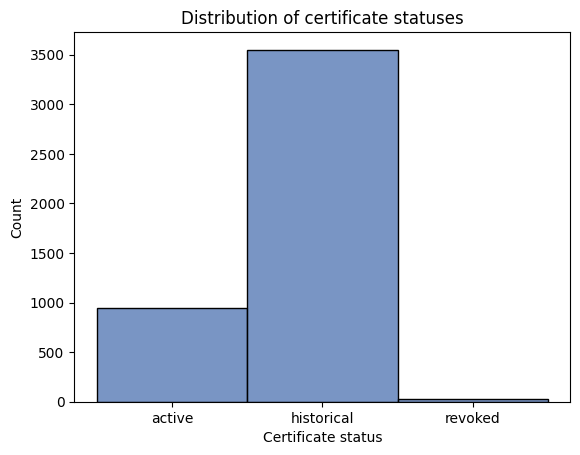

In [32]:
sns.histplot(data=df["status"])
plt.title("Distribution of certificate statuses")
plt.xlabel("Certificate status")
plt.show()

### Type distribution of certificates

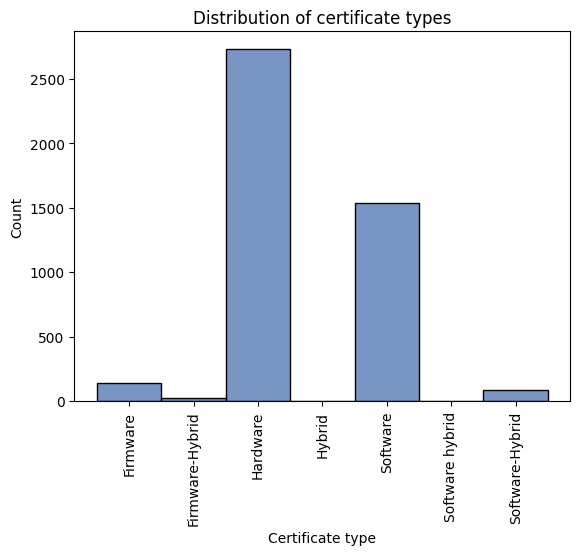

In [31]:
sns.histplot(data=df["type"])
plt.title("Distribution of certificate types")
plt.xlabel("Certificate type")
plt.xticks(rotation=90) 
plt.show()

### Standard distribution of certificates

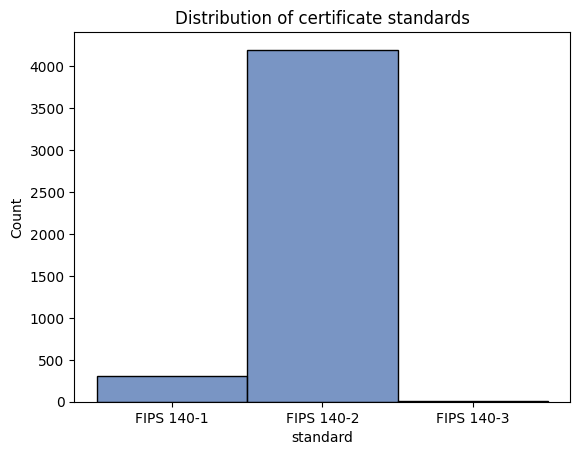

In [41]:
sns.histplot(data=df["standard"])
plt.title("Distribution of certificate standards")
plt.show()

### Distribution of embodiment in the dataset

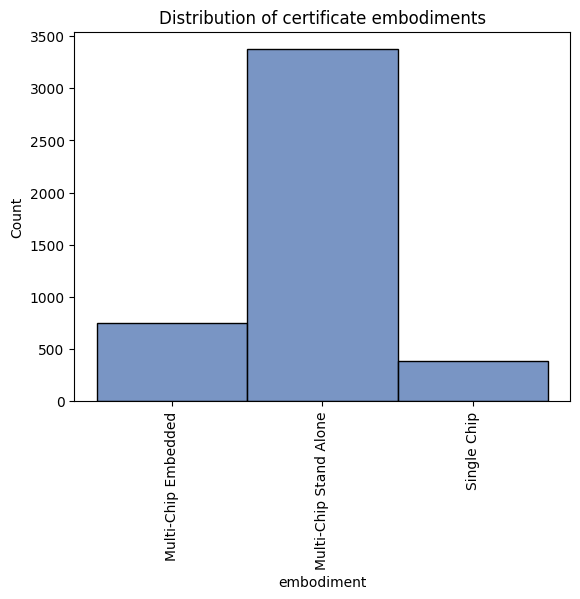

In [44]:
sns.histplot(data=df["embodiment"])
plt.title("Distribution of certificate embodiments")
plt.xticks(rotation=90) 
plt.show()

### Five most common CVEs in the dataset

In [52]:
cve_certs_df = df[df["related_cves"].notna()]

print(f"Number of certificates with at least one CVE: {cve_certs_df.shape[0]}")

Number of certificates with at least one CVE: 220


In [63]:
cve_counter = Counter()

for cves in cve_certs_df["related_cves"]:
    cve_counter.update(cves)

cve_counter.most_common(5)

[('CVE-2016-7091', 49),
 ('CVE-1999-0037', 45),
 ('CVE-2001-0889', 45),
 ('CVE-2007-3103', 45),
 ('CVE-1999-1288', 45)]

### Five most common crypto algorithms used

In [72]:
crypto_algo_counter = Counter()

for algorithms in df["algorithms"]:
    crypto_algo_counter.update(algorithms)

crypto_algo_counter.most_common(5)

[('RSA#1', 180),
 ('Triple-DES#34', 45),
 ('ECDSA#368', 35),
 ('AES#2273', 35),
 ('DRBG#281', 35)]

## Analysis of FIPS references

In [46]:
# TODO